# Flujo de Tarea

1 - Tenemos un listado de clientes 

2 - Cada cliente tiene sus stocks en cartera

3 - Nuestra misión es:
    
    * Leer ese listado
    * Ver para cada cliente si alguno de sus activos esta entrando en bear-mkt
    * En caso afirmativo:
        * Preparar reporte de opciones en un rango dado de vencimientos 
        * Mandarle un mail avisando potencial bearMkt y adjuntarle listado de coberturas
    * A todos los clientes:
        * Mandar un reporte semanal con info de su cartera (ej: variaciones semanales y mensuales por activo)
        * Adjuntar un gráfico en el mail con variacion de sus activos en base100 ultimos 30 días
    * Guardar en carpeta de cada cliente todos los reportes separados (el texto, la imagen, el excel de coberturas)
    * Enviar un mail con el texto, la imagen y los excels de coberturas al cliente
    * Guardar un ZIP en la carpeta del cliente con todos lo enviado por email, por fecha
    * Borrar los excels sueltos que habiamos guardado para enviar el email
    

<img src="imagenes/diagrama_de_flujo.svg" width=800>

## Leer listado de clientes

### Ver path actual

In [1]:
import os

os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant'

### Crear Directorio

In [2]:
if not os.path.exists('clase_backoffice'):
    os.mkdir('clase_backoffice')
else:
    print('el directorio ya existe en el path:')
    path = os.getcwd()
    print(path)

### Ir a directorio determinado

In [3]:
if os.path.exists('clase_backoffice'):
    os.chdir("clase_backoffice")
    print('Nos movimos al directorio:')
    path = os.getcwd()
    print(path)    
else:
    print('El directorio no existe en el path actual:')
    path = os.getcwd()
    print(path)

Nos movimos al directorio:
C:\Users\Usuario\Desktop\cursos_2021\PreQuant\clase_backoffice


In [4]:
clientes = [{'nombre':'cliente_1', 'email':'clasespython2020@gmail.com', 'stocks':'AAPL,FB'},
            {'nombre':'cliente_2', 'email':'clasespython2020@gmail.com', 'stocks':'AMZN,NFLX,JPM'},
            {'nombre':'cliente_3', 'email':'clasespython2020@gmail.com', 'stocks':'KO,PG,VZ'}
           ]

In [5]:
import pandas as pd

pd.DataFrame(clientes).to_excel('clientes.xlsx',index=False)

### Retroceder directorio

In [6]:
os.chdir('..')

In [7]:
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant'

### Ahora si voy a leer listado

In [8]:
import pandas as pd

directorio = r'C:\Users\Usuario\Desktop\cursos_2021\PreQuant\clase_backoffice'
directorio = 'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant\\clase_backoffice'
directorio = 'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice'

os.chdir(directorio)
clientes = pd.read_excel("clientes.xlsx", index_col='nombre')
clientes

,email,stocks
nombre,,
cliente_1,clasespython2020@gmail.com,"AAPL,FB"
cliente_2,clasespython2020@gmail.com,"AMZN,NFLX,JPM"
cliente_3,clasespython2020@gmail.com,"KO,PG,VZ"


### Para cada cliente armo una lista de activos

In [9]:
stocks = {}
emails = {}

for cliente in clientes.index.values:
    stocks[cliente] = clientes.loc[cliente,'stocks'].split(',')
    emails[cliente] = clientes.loc[cliente,'email']
    
stocks

{'cliente_1': ['AAPL', 'FB'],
 'cliente_2': ['AMZN', 'NFLX', 'JPM'],
 'cliente_3': ['KO', 'PG', 'VZ']}

In [10]:
emails

{'cliente_1': 'clasespython2020@gmail.com',
 'cliente_2': 'clasespython2020@gmail.com',
 'cliente_3': 'clasespython2020@gmail.com'}

## Preparar datos

En este caso, voy a leer data historica de cada activo y calcular 

    * La volatilidad histórica (usaremos 40 ruedas)
    * La variación % ultimos 7 días y 30 días

Condición para mandar reporte con puts sugeridos:

    * variación semanal es menor a -2%
    * variación mensual menor a -5%

Puts sugeridos:

    * Vencimientos de 20 a 90 días
    * Volatilidad implícita menor a la 2 * histórica en 40 ruedas

In [11]:
import requests
import pandas as pd

c_key = "NYF6LZZITQAOCYNQHYUZOJF4XGDPT0KK"

In [12]:
def getHist(symbol, periodT='day', period=1, freqT='minute', freq=1, na='true'):
    
    params = {'symbol':symbol, 'periodType':periodT, 'period':period, 
              'apikey' : c_key, 'frequencyType':freqT, 'frequency':freq ,
              'needExtendedHoursData':na}
    
    url_base='https://api.tdameritrade.com/v1/marketdata/'
    
    endpoint = url_base + symbol+'/pricehistory'
    
    r = requests.get(url=endpoint, params=params)  # data, json
    try:
        js = r.json()['candles']
        df = pd.DataFrame(js)
        df['fecha'] = pd.to_datetime(df.datetime - 3600*1000*3, unit='ms')
        df = df.set_index('fecha')
    except:
        print('Error, ojo que tenemos una rta inesperada', r.json())
        df = pd.DataFrame()
        
    return df

In [13]:
def options(symbol, days_f=0, days_t=0):
    params = {'apikey' : c_key, 'symbol':symbol}
    endpoint = 'https://api.tdameritrade.com/v1/marketdata/chains'
    r = requests.get(url=endpoint ,params=params)
    
    chain = r.json()
    v_calls = list(chain['callExpDateMap'].values())
    v_calls_fechas = list(chain['callExpDateMap'].keys())
    v_puts = list(chain['putExpDateMap'].values())
    v_puts_fechas = list(chain['putExpDateMap'].keys())

    calls = []
    for i in range(len(v_calls)):
        v = list(v_calls[i].values())    
        for j in range(len(v)):
            calls.append(v[j][0])

    puts = []
    for i in range(len(v_puts)):
        v = list(v_puts[i].values())    
        for j in range(len(v)):
            puts.append(v[j][0])

    contracts = pd.concat([pd.DataFrame(calls),pd.DataFrame(puts)])    
            
    if (days_f > 0) & (days_t)>0:
        try:
            contracts = contracts.loc[(contracts.daysToExpiration > days_f) & (contracts.daysToExpiration < days_t)]

        except:
            print(f"ERROR: {symbol} \n {contracts}")

    
    try:
        contracts = contracts.loc[:,['strikePrice','daysToExpiration','putCall','bid','ask',
                             'last','volatility','openInterest', 'theoreticalOptionValue',
                              'delta', 'gamma', 'theta', 'vega', 'rho']]

        contracts.columns = ['Strike','Dias','Tipo','Bid','Ask', 'Ultimo','VI','OpenInt','PrimaT', 
                             'delta', 'gamma', 'theta', 'vega', 'rho']

    except:
        print(f"ERROR: {symbol} \n {contracts}")
        
    return contracts

In [14]:
data = getHist('GGAL', periodT='year', period=20, freqT='daily', freq=1, na='false')
data['VH'] = data.close.pct_change().rolling(40).std() * 250**0.5 *100
data['v_semanal'] = (data.close / data.close.shift(5) - 1) *100 
data['v_mensual'] = (data.close / data.close.shift(30) - 1) *100
data = data.round(2)

vh, v_semanal, v_mensual = data.iloc[-1,-3:]
vh, v_semanal, v_mensual

(44.17, -2.42, 29.62)

In [15]:
contracts = options('AAPL')
contracts

,Strike,Dias,Tipo,Bid,Ask,Ultimo,VI,OpenInt,PrimaT,delta,gamma,theta,vega,rho
0,65.0,5,CALL,65.35,65.50,65.91,123.842,2,65.460,1.000,0.000,0.000,0.000,0.000
1,70.0,5,CALL,60.35,60.50,60.96,113.775,20,60.460,1.000,0.000,0.000,0.000,0.000
2,75.0,5,CALL,55.35,55.50,55.95,107.167,10,55.460,1.000,0.000,0.000,0.000,0.000
3,80.0,5,CALL,50.35,50.50,48.81,99.860,10,50.460,1.000,0.000,0.000,0.000,0.000
4,85.0,5,CALL,45.35,45.50,45.60,92.290,38,45.460,1.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,220.0,726,PUT,92.35,92.85,91.83,30.696,11,93.260,-0.837,0.004,-0.009,0.452,-4.039
868,230.0,726,PUT,101.80,102.30,101.20,31.075,10,102.690,-0.857,0.004,-0.008,0.414,-4.279
869,240.0,726,PUT,111.30,111.80,111.11,31.476,119,112.225,-0.873,0.004,-0.008,0.381,-4.512
870,250.0,726,PUT,120.90,121.40,120.19,31.944,53,121.860,-0.887,0.003,-0.007,0.352,-4.739


In [16]:
import time
def prepararData(stocks):
    reportes = {}
    for cliente, stocks in stocks.items():
        reportes[cliente] = {}
        for i, stock in enumerate(stocks):
            print (f"Procesando Cliente: {cliente}, stock: {i+1}/{len(stocks)} {stock}     ", end='\r')
            data = getHist(stock, periodT='year', period=20, freqT='daily', freq=1, na='false')
            data['VH'] = data.close.pct_change().rolling(40).std() * 250**0.5 *100
            data['v_semanal'] = (data.close / data.close.shift(5) - 1) *100 
            data['v_mensual'] = (data.close / data.close.shift(30) - 1) *100
            data = data.round(2)
            base_100 = data.close.iloc[-30:] / data.close.iloc[-30] *100
            vh, v_semanal, v_mensual = data.iloc[-1,-3:]

            # Busco opciones entre plazos establecidos
            contracts = options(stock, days_f=20, days_t=90)
                                
            condicion = (v_semanal < -2) | (v_mensual < -5)
            coberturas = contracts if condicion else pd.DataFrame()
            
            
            reportes[cliente][stock] = {'v_semanal':v_semanal, 'v_mensual':v_mensual, 'base_100':base_100,
                                        'VH':vh,'cubrir': condicion, 'opciones':coberturas}
            
            time.sleep(0.5)
    return reportes

In [17]:
reportes = prepararData(stocks)

## Carpetas por Cliente

In [18]:
import datetime

def prepararCarpetas(reportes):
    hoy = datetime.date.today().isoformat()

    for cliente, reporte in reportes.items():
        bases_100 = []

        print(cliente)

        if not os.path.exists(cliente):
            os.mkdir(cliente)

        os.chdir(cliente)

        texto = f"Estimado cliente {cliente}\n"
        texto += f"Reporte semanal preparado: {hoy} \n\n"


        for stock, rep in reporte.items():
            bases_100.append(rep['base_100'])

            if rep['cubrir']:
                texto += f"\nSu activo {stock} se encuentra en riesgo bajista,"
                texto += " le adjuntamos una lista de opciones posibles para que piense estrategia de cobertura"

                if len(rep['opciones']) > 0:
                    rep['opciones'].to_excel(f'{hoy}_{stock}.xlsx')

            else:
                texto += f"Su activo {stock} no se encuentra en riesgo bajista,"
                texto += f" presenta una variacion semanal del {rep['v_semanal']}%"
                texto += f" y una variacion mensual del {rep['v_mensual']}% \n"

        portafolio = pd.concat(bases_100, axis=1)
        portafolio.columns = reporte.keys()

        base_100_img = pd.DataFrame(portafolio).plot().get_figure()
        base_100_img.savefig(f'portafolio_{hoy}.jpg')

        with open(f'email_{hoy}.txt', 'w') as f:
            f.write(texto)

        os.chdir('..')

cliente_1
cliente_2
cliente_3


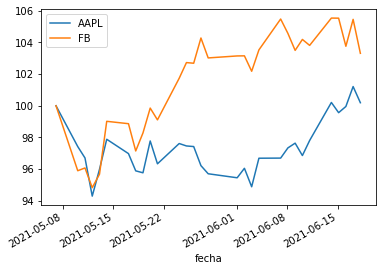

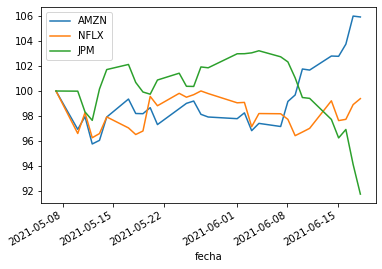

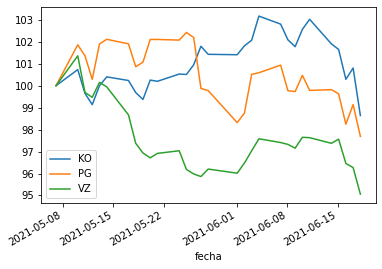

In [19]:
prepararCarpetas(reportes)

## Envio de emails

### Autorizacion de uso de scripting para la cuenta de gmail

https://myaccount.google.com/lesssecureapps

### Envio de emails simples

In [20]:
os.chdir(r'C:\Users\Usuario\Desktop\cursos_2021\PreQuant')
from gmail_password import *

os.chdir(r'C:\Users\Usuario\Desktop\cursos_2021\PreQuant\clase_backoffice')

In [21]:
import smtplib

remitente = "clasespython2020@gmail.com"
# gmail_password = 'mi_clave_correo_remitente'

destinatario = "clasespython2020@gmail.com"

In [22]:
file = r'C:\Users\Usuario\Desktop\cursos_2021\PreQuant\clase_backoffice\cliente_2\email_2021-06-20.txt'
with open(file) as f:
    lines = f.readlines()

text = ''.join(lines)
text

'Estimado cliente cliente_2\nReporte semanal preparado: 2021-06-20 \n\nSu activo AMZN no se encuentra en riesgo bajista, presenta una variacion semanal del 4.19% y una variacion mensual del 5.46% \nSu activo NFLX no se encuentra en riesgo bajista, presenta una variacion semanal del 2.46% y una variacion mensual del 0.24% \n\nSu activo JPM se encuentra en riesgo bajista, le adjuntamos una lista de opciones posibles para que piense estrategia de cobertura'

In [23]:
hoy = datetime.date.today().isoformat()

# Instancio el objeto de conexión al server de gmail
server = smtplib.SMTP("smtp.gmail.com", 587)

# inicio sesión segura
server.starttls()

# Me logueo con las credenciales
server.login(remitente, gmail_password)


for cliente, reporte in reportes.items():    
    file = f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}/email_{hoy}.txt'
    with open(file) as f:
        lines = f.readlines()

    body = ''.join(lines)
    subject = f'Hola, {cliente} Reporte Curso Ucema {hoy}'

    print(f"Enviando mensaje a: {cliente}")

    msg = f'Subject: {subject}\n\n{body}'

    # Envío el email
    server.sendmail(remitente, destinatario, msg)


# Cierro la conexión
server.quit()

Enviando mensaje a: cliente_1
Enviando mensaje a: cliente_2
Enviando mensaje a: cliente_3


(221, b'2.0.0 closing connection u23sm6621555qkk.83 - gsmtp')

### Leer archivos de un directorio

In [24]:
cliente = 'cliente_2'
os.chdir(f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}')

archivos = [x.name for x in os.scandir() if not x.is_dir()]
archivos

['2021-06-20_JPM.xlsx', 'email_2021-06-20.txt', 'portafolio_2021-06-20.jpg']

### Envio de Emails con Adjuntos

In [25]:
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import smtplib

In [26]:
def enviarEamils(reportes, emails):
    # Inicio Sesion
    session = smtplib.SMTP('smtp.gmail.com:587') 
    session.ehlo()
    session.starttls() 
    session.login(remitente, gmail_password) 

    for cliente, reporte in reportes.items():    
        file = f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}/email_{hoy}.txt'
        with open(file) as f:
            lines = f.readlines()

        body = ''.join(lines)
        subject = f'Hola, {cliente} Reporte Curso Ucema {hoy}'

        print(f"Enviando mensaje a: {cliente}")


        # Preparo mensaje
        message = MIMEMultipart()
        message['From'] = remitente
        message['To'] = emails[cliente]
        message['Subject'] = subject
        mail_content = body

        message.attach(MIMEText(mail_content, 'plain'))

        # Adjunto los archivos que quiera
        os.chdir(f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}/')
        archivos = [x.name for x in os.scandir() if not x.is_dir()]

        for archivo in archivos:    
            file = open(archivo, 'rb') 
            payload = MIMEBase('application', 'octate-stream')
            payload.set_payload((file).read())
            encoders.encode_base64(payload) 
            payload.add_header('Content-Disposition', 'attachment; filename="'+archivo+'"')
            message.attach(payload)

        # Envio el email 
        session.sendmail(remitente, destinatario, message.as_string())

    # Cierro Sesion
    session.quit()

In [27]:
enviarEamils(reportes, emails)

Enviando mensaje a: cliente_1
Enviando mensaje a: cliente_2
Enviando mensaje a: cliente_3


## Compresión

In [28]:
import zipfile
import os

def compress(file_names):
    path = os.getcwd()
    hoy = datetime.date.today().isoformat()
    zf = zipfile.ZipFile(f"comprimido_{hoy}.zip", mode="w")
    for file_name in file_names:
        zf.write(path +'\\'+ file_name, file_name, compress_type=zipfile.ZIP_DEFLATED)
    zf.close()

def comprimirEliminar(reportes):
    for cliente in reportes.keys():    
        os.chdir(f'C:/Users/Usuario/Desktop/cursos_2021/PreQuant/clase_backoffice/{cliente}/')
        archivos = [x.name for x in os.scandir() if not x.is_dir()]
        compress(archivos)
        for archivo in archivos:        
            extension = archivo.split('.')[-1]
            if extension != "zip":
                os.remove(archivo)

In [29]:
comprimirEliminar(reportes)

# Todo con funciones

In [30]:
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant\\clase_backoffice\\cliente_3'

In [31]:
os.chdir('..')
os.getcwd()

'C:\\Users\\Usuario\\Desktop\\cursos_2021\\PreQuant\\clase_backoffice'

In [32]:
clientes = [{'nombre':'oso', 'email':'clasespython2020@gmail.com', 'stocks':'TSLA'},
                    {'nombre':'juanfer', 'email':'clasespython2020@gmail.com', 'stocks':'AAL,DAL'},
                    {'nombre':'pity', 'email':'clasespython2020@gmail.com', 'stocks':'PFE'}
                   ]


pd.DataFrame(clientes).to_excel('clientes.xlsx', index=False)
clientes = pd.read_excel("clientes.xlsx", index_col='nombre')

stocks, emails = {}, {}
for cliente in clientes.index.values:
    stocks[cliente] = clientes.loc[cliente,'stocks'].split(',')
    emails[cliente] = clientes.loc[cliente,'email']
    
stocks, emails

({'oso': ['TSLA'], 'juanfer': ['AAL', 'DAL'], 'pity': ['PFE']},
 {'oso': 'clasespython2020@gmail.com',
  'juanfer': 'clasespython2020@gmail.com',
  'pity': 'clasespython2020@gmail.com'})

osocesando Cliente: pity, stock: 1/1 PFE        
juanfer
pity
Enviando mensaje a: oso
Enviando mensaje a: juanfer
Enviando mensaje a: pity


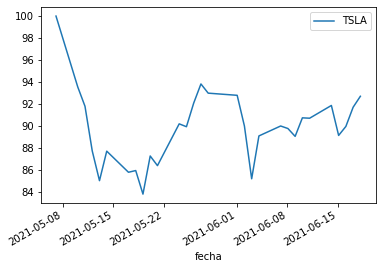

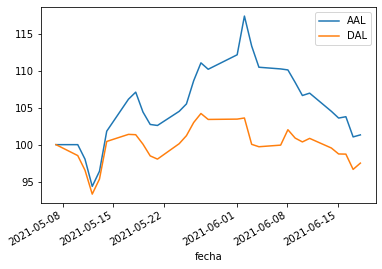

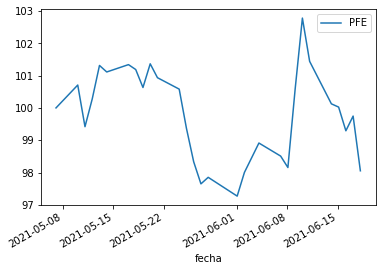

In [33]:
reportes = prepararData(stocks)
prepararCarpetas(reportes)
enviarEamils(reportes, emails)
comprimirEliminar(reportes)

# Plus: Leer bandeja y buscar

In [34]:
import imaplib

imap_ssl_host = 'imap.gmail.com'
server = imaplib.IMAP4_SSL(imap_ssl_host)
server.login('clasespython2020@gmail.com', gmail_password)

('OK', [b'clasespython2020@gmail.com authenticated (Success)'])

In [35]:
server.select('Inbox')
status, nums = server.search(None, 'ALL')

In [36]:
print(nums[0].decode().split())

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57']


In [37]:
import imaplib
import pandas as pd

def leerCarpeta(cuenta, gmail_password, limit=10, carpeta='Inbox', query='ALL'):

    imap_ssl_host = 'imap.gmail.com'
    server = imaplib.IMAP4_SSL(imap_ssl_host)
    server.login(cuenta, gmail_password)

    server.select(carpeta)
    status, nums = server.search(None, query)

    count = 0
    results = []
    for num in nums[0].split()[::-1]:

        count += 1
        status, data = server.fetch(num, '(BODY.PEEK[HEADER])')
        email = data[0][1].decode().split('\r\n')

        r = {}
        for line in email:
            for clave in ['Subject', 'Date', 'From']:
                if line.find(clave) == 0:
                    r[clave] = line[len(clave)+2:]
        results.append(r)

        if count == limit:
            break

    return pd.DataFrame(results)

In [39]:
leerCarpeta('clasespython2020@gmail.com', gmail_password, limit=10, carpeta='Inbox', query='ALL')

,Date,From,Subject
0,"Sun, 20 Jun 2021 17:19:57 -0700 (PDT)",clasespython2020@gmail.com,"Hola, pity Reporte Curso Ucema 2021-06-20"
1,"Sun, 20 Jun 2021 17:19:55 -0700 (PDT)",clasespython2020@gmail.com,"Hola, juanfer Reporte Curso Ucema 2021-06-20"
2,"Sun, 20 Jun 2021 17:19:51 -0700 (PDT)",clasespython2020@gmail.com,"Hola, oso Reporte Curso Ucema 2021-06-20"
3,"Sun, 20 Jun 2021 17:18:01 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_3 Reporte Curso Ucema 2021-06-20"
4,"Sun, 20 Jun 2021 17:17:58 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_2 Reporte Curso Ucema 2021-06-20"
5,"Sun, 20 Jun 2021 17:17:57 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_1 Reporte Curso Ucema 2021-06-20"
6,"Sun, 20 Jun 2021 17:17:32 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_3 Reporte Curso Ucema 2021-06-20"
7,"Sun, 20 Jun 2021 17:17:31 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_2 Reporte Curso Ucema 2021-06-20"
8,"Sun, 20 Jun 2021 17:17:30 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_1 Reporte Curso Ucema 2021-06-20"
9,"Sun, 20 Jun 2021 05:45:52 GMT",Google <no-reply@accounts.google.com>,=?UTF-8?Q?Alerta_de_seguridad_cr=C3=ADtica?=


In [40]:
leerCarpeta('clasespython2020@gmail.com', gmail_password, limit=10, carpeta='Inbox', query='(SEEN BODY UCEMA)')

,Date,From,Subject
0,"Sun, 20 Jun 2021 17:17:58 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_2 Reporte Curso Ucema 2021-06-20"
1,"Sun, 20 Jun 2021 17:17:57 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_1 Reporte Curso Ucema 2021-06-20"
2,"Sun, 20 Jun 2021 17:17:30 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_1 Reporte Curso Ucema 2021-06-20"


In [41]:
leerCarpeta('clasespython2020@gmail.com', gmail_password, limit=10, carpeta='Inbox', 
            query='(NOT SEEN TO clasespython2020@gmail.com)')

,Date,From,Subject
0,"Sun, 20 Jun 2021 17:19:57 -0700 (PDT)",clasespython2020@gmail.com,"Hola, pity Reporte Curso Ucema 2021-06-20"
1,"Sun, 20 Jun 2021 17:19:55 -0700 (PDT)",clasespython2020@gmail.com,"Hola, juanfer Reporte Curso Ucema 2021-06-20"
2,"Sun, 20 Jun 2021 17:19:51 -0700 (PDT)",clasespython2020@gmail.com,"Hola, oso Reporte Curso Ucema 2021-06-20"
3,"Sun, 20 Jun 2021 17:18:01 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_3 Reporte Curso Ucema 2021-06-20"
4,"Sun, 20 Jun 2021 17:17:32 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_3 Reporte Curso Ucema 2021-06-20"
5,"Sun, 20 Jun 2021 17:17:31 -0700 (PDT)",clasespython2020@gmail.com,"Hola, cliente_2 Reporte Curso Ucema 2021-06-20"
6,"Sun, 20 Jun 2021 05:45:52 GMT",Google <no-reply@accounts.google.com>,=?UTF-8?Q?Alerta_de_seguridad_cr=C3=ADtica?=
7,"Fri, 18 Jun 2021 11:19:01 -0700",Google <google-noreply@google.com>,=?UTF-8?Q?=E2=9A=A0=EF=B8=8F_Usaste_el_76=25_d...
8,"Thu, 10 Jun 2021 20:43:10 -0500","""Finbox"" <manuel.bleve@finbox.com>",There is a theme amongst top performing companies
9,"Tue, 08 Jun 2021 20:41:09 -0500","""Finbox"" <manuel.bleve@finbox.com>",Ideas From Top Portfolios To Help You


In [45]:
leerCarpeta('clasespython2020@gmail.com', gmail_password, limit=2, carpeta='Inbox', 
            query='(SENTBEFORE 01-nov-2020)')

,Date,From,Subject
0,"Sun, 25 Oct 2020 13:39:11 -0700 (PDT)",clasespython2020@gmail.com,Cryptos correlation para scalping
1,"Sun, 25 Oct 2020 13:16:08 -0700 (PDT)",clasespython2020@gmail.com,Cryptos correlation para scalping


## Mas queries

https://datatracker.ietf.org/doc/html/rfc3501.html#section-6.4.4